### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

### Load data

In [44]:
train_df = pd.read_csv("/data/train.csv", sep = ',')
roc = pd.read_csv("oof-variant-1.csv", sep = ',')
prauc = pd.read_csv("oof-variant-2.csv", sep = ',')
predictions = pd.read_csv("predictions-variant-2.csv", sep = ',')
roc.columns = ["oof"]
prauc.columns = ["oof"]

### OOF histogram variant 1

Text(0.5, 1.0, 'Model predictions histogram')

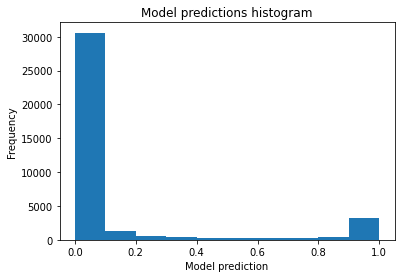

In [56]:
plt.hist(roc["oof"])
plt.xlabel("Model prediction")
plt.ylabel("Frequency")
plt.title("Model predictions histogram")

### OOF histogram variant 2

(array([31616.,   744.,   277.,   200.,   145.,   135.,    78.,    98.,
          122.,  4233.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

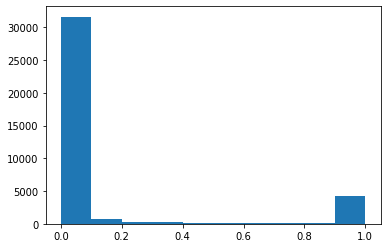

In [4]:
plt.hist(prauc["oof"])
plt.xlabel("Model prediction")
plt.ylabel("Frequency")
plt.title("Model predictions histogram")

### AUC for variants

In [57]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# ROC on full Training data
print('OOF variant 1 AUC: {:.3f}'.format(roc_auc_score(train_df['target'], roc)))
print('OOF variant 2 AUC: {:.3f}'.format(roc_auc_score(train_df['target'], prauc)))

OOF variant 1 AUC: 0.961
OOF variant 2 AUC: 0.972


### Data processing

In [32]:
df = pd.DataFrame()
df["y_pred"] = roc["oof"]
def binarize(x):
    if x >= 0.5:
        x = 1
    else:
        x = 0
    return x
df["y_pred_binary"] = df["y_pred"].apply(lambda x: binarize(x))
df = pd.concat([df,train_df],axis=1)
df.reset_index(inplace=True, drop=True)
df.head()

,y_pred,y_pred_binary,image_id,patient_id,sex,age,anatomy,target
0,0.0,0,ISIC_2637011,IP_7279968,1,45.0,0,0
1,0.0,0,ISIC_0015719,IP_3075186,0,45.0,5,0
2,0.0,0,ISIC_0052212,IP_2842074,0,50.0,1,0
3,0.0,0,ISIC_0068279,IP_6890425,0,45.0,0,0
4,0.0,0,ISIC_0074268,IP_8723313,0,55.0,5,0


### Variant 1 confusion matrix

<AxesSubplot:>

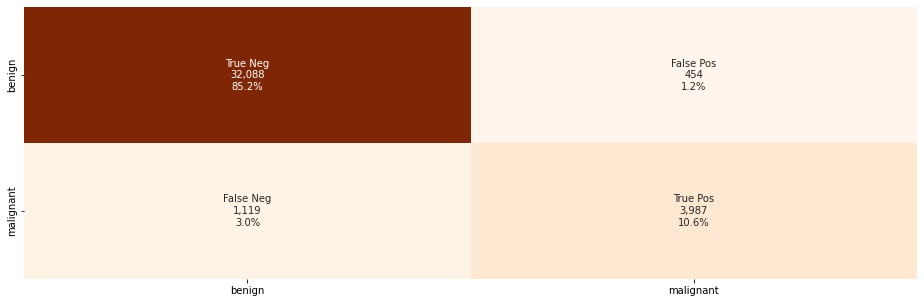

In [6]:
# Make OOF Binary
roc.loc[roc.oof >= 0.5, 'oof'] = 1
roc.loc[roc.oof < 0.5, 'oof'] = 0

# Create Confusion Matrix
cf_matrix = confusion_matrix(train_df['target'], roc)

# Pretty CM:
group_names = ['True Neg','False Pos','False Neg','True Pos']
# Format of the absolute numbers
group_counts = ['{:,}'.format(value) for value in cf_matrix.flatten()]
# Format for relative numbers
group_percentages = ['{0:.1%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# --- The figure ---
plt.figure(figsize=(16, 5))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges',xticklabels=['benign', 'malignant'], 
            yticklabels=['benign', 'malignant'], cbar=False)plt.hist(roc["oof"])

### True positives, False Positives, True Negatives, False Negatives

In [33]:
TP = []
FP = []
TN = []
FN = []

for index, row in df.iterrows():
    y_pred = row["y_pred_binary"]
    y_true = row["target"]
    if y_true == y_pred == 1:
        TP.append(row)
    if y_pred==1 and y_true!=y_pred:
        FP.append(row)
    if y_true==y_pred==0:
        TN.append(row)
    if y_pred==0 and y_true!=y_pred:
        FN.append(row)
        
TP = pd.DataFrame(TP)
FP = pd.DataFrame(FP)
TN = pd.DataFrame(TN)
FN = pd.DataFrame(FN)

### Display small samples

In [35]:
n = 2
print("True negatives:")
display(TN.sample(n))
print("True positives:")
display(TP.sample(n))
print("False negatives:")
display(FN.sample(n))
print("False positives:")
display(FP.sample(n))

True negatives:


,y_pred,y_pred_binary,image_id,patient_id,sex,age,anatomy,target
19232,0.0,0,ISIC_5836421,IP_9453080,0,55.0,5,0
13912,0.0,0,ISIC_4266571,IP_6323321,1,35.0,4,0


True positives:


,y_pred,y_pred_binary,image_id,patient_id,sex,age,anatomy,target
36605,1.0,1,ISIC_0065675,BCN_0001367,0,85.0,1,1
34698,1.0,1,ISIC_0033946,HAM_0007343,1,70.0,0,1


False negatives:


,y_pred,y_pred_binary,image_id,patient_id,sex,age,anatomy,target
35452,0.0,0,ISIC_0057889,BCN_0005637,1,70.0,1,1
33458,0.0,0,ISIC_0013696_downsampled,MSK4_0010736,1,70.0,3,1


False positives:


,y_pred,y_pred_binary,image_id,patient_id,sex,age,anatomy,target
5813,1.0,1,ISIC_1845450,IP_1039004,0,75.0,1,0
28976,1.0,1,ISIC_8767074,IP_2107539,1,50.0,0,0


### Data processing

In [46]:
df = pd.DataFrame()
df["y_pred"] = prauc["oof"]
def binarize(x):
    if x >= 0.5:
        x = 1
    else:
        x = 0
    return x
df["y_pred_binary"] = df["y_pred"].apply(lambda x: binarize(x))
df = pd.concat([df,train_df],axis=1)
df.reset_index(inplace=True, drop=True)
df.head()

,y_pred,y_pred_binary,image_id,patient_id,sex,age,anatomy,target
0,0.000796,0,ISIC_2637011,IP_7279968,1,45.0,0,0
1,0.000073,0,ISIC_0015719,IP_3075186,0,45.0,5,0
2,0.000014,0,ISIC_0052212,IP_2842074,0,50.0,1,0
3,0.004735,0,ISIC_0068279,IP_6890425,0,45.0,0,0
4,0.000014,0,ISIC_0074268,IP_8723313,0,55.0,5,0


### Variant 2 confusion matrix

<AxesSubplot:>

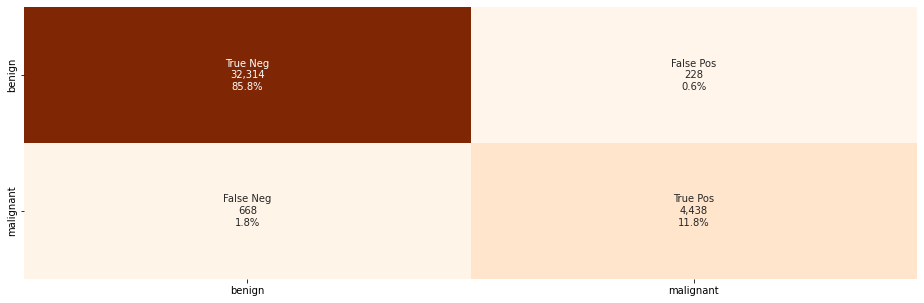

In [49]:
# Create Confusion Matrix
cf_matrix = confusion_matrix(train_df['target'], df["y_pred_binary"])

# Pretty CM:
group_names = ['True Neg','False Pos','False Neg','True Pos']
# Format of the absolute numbers
group_counts = ['{:,}'.format(value) for value in cf_matrix.flatten()]
# Format for relative numbers
group_percentages = ['{0:.1%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# --- The figure ---
plt.figure(figsize=(16, 5))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges',xticklabels=['benign', 'malignant'], 
            yticklabels=['benign', 'malignant'], cbar=False)

### True positives, False Positives, True Negatives, False Negatives

In [50]:
TP = []
FP = []
TN = []
FN = []

for index, row in df.iterrows():
    y_pred = row["y_pred_binary"]
    y_true = row["target"]
    if y_true == y_pred == 1:
        TP.append(row)
    if y_pred==1 and y_true!=y_pred:
        FP.append(row)
    if y_true==y_pred==0:
        TN.append(row)
    if y_pred==0 and y_true!=y_pred:
        FN.append(row)
        
TP = pd.DataFrame(TP)
FP = pd.DataFrame(FP)
TN = pd.DataFrame(TN)
FN = pd.DataFrame(FN)

### Display small samples

In [ ]:
n = 3
print("True negatives:")
display(TN.sample(n))
print("True positives:")
display(TP.sample(n))
print("False negatives:")
display(FN.sample(n))
print("False positives:")
display(FP.sample(n))

### Precision Recall ROC variant 2

Model: f1=0.908 auc=0.919


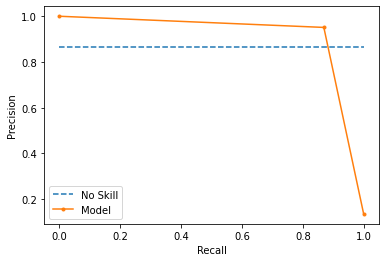

In [54]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


precision, recall, _ = precision_recall_curve(df["target"], df["y_pred_binary"])
f1, auc = f1_score(df["target"], df["y_pred_binary"]), auc(recall, precision)
# summarize scores
print('Model: f1=%.3f auc=%.3f' % (f1, auc))
# plot the precision-recall curves
no_skill = len(df["target"][df["target"]==0]) / len(df["target"])
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Model')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()